In [2]:
#This creates three distance matrices based on trees.
from Bio import Phylo
import numpy as np

def compute_distance_matrix(tree, reference_taxa):
    """Generate a normalized distance matrix with taxa ordered as reference_taxa."""
    num_taxa = len(reference_taxa)
    distance_matrix = np.zeros((num_taxa, num_taxa))

    # Compute pairwise distances
    for i, taxon1 in enumerate(reference_taxa):
        for j, taxon2 in enumerate(reference_taxa):
            if i != j:
                distance_matrix[i, j] = tree.distance(taxon1, taxon2)

    # Normalize distances (Min-Max scaling)
    min_val, max_val = np.min(distance_matrix), np.max(distance_matrix)
    if max_val > min_val:  # Avoid division by zero
        distance_matrix = (distance_matrix - min_val) / (max_val - min_val)

    return distance_matrix

def process_trees(newick_files):
    """Compute ordered and normalized distance matrices for multiple trees using a fixed reference order."""
    trees = [Phylo.read(file, "newick") for file in newick_files]
    
    # Use leaf order from the first tree as the reference
    reference_taxa = [term.name for term in trees[0].get_terminals()]
    
    matrices = {file: compute_distance_matrix(tree, reference_taxa) for file, tree in zip(newick_files, trees)}
    
    return reference_taxa, matrices

# Example usage
StructureTreeFile = "C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/158 SCOP CYPP450s Seq_Struct_Analysis/Trees/FoldTree_of_158_AF_Structs.nwk"
PCDTWTreeFile = "C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/158 SCOP CYPP450s Seq_Struct_Analysis/Trees/MWHPPCDTW_of_158_UniProt_Seqs2.nwk"
SequenceAlignTreeFile = "C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/158 SCOP CYPP450s Seq_Struct_Analysis/Trees/ClustalO_of_158_PDB_Structs.nwk"

newick_files = [StructureTreeFile, PCDTWTreeFile, SequenceAlignTreeFile]
reference_taxa, distance_matrices = process_trees(newick_files)

print("\nReference Taxa Order:", reference_taxa)
for file, matrix in distance_matrices.items():
    print(f"\nNormalized Distance Matrix for {file}:")
    print(matrix)




Reference Taxa Order: ['Bact_CYP51_Q603T8', 'Bact_CYP51_P9WPP9', 'Proto_CYP_A2TEF2', 'Proto_CYP_Q385E8', 'Proto_CYP51_Q7Z1V1', 'Hum_CYP51A1_Q16850', 'Proto_CYP51_A0A2H4A2U9', 'Proto_CYP_L8GJB3', 'Fung_CP51B_E9QY26', 'Fung_CYP51_P50859', 'Fung_CYP51_P10614', 'Fung_CYP_A6ZSR0', 'Hum_CYP3A5_P20815', 'Hum_CYP3A7_P24462', 'Hum_CYP3A4_P08684', 'Fung_CYP_G2QDZ3', 'Bact_CYP_A0A2I9DQ46', 'Bact_CYP_F2Q7T0', 'Bact_CYP102A1_P14779', 'Bact_CYP_A0A1Q8UP87', 'Hum_CP21A_P08686', 'Bov_CP21A_P00191', 'Hum_CYP17A1_P05093', 'Fsh_CYP17A1_B3DH80', 'Fsh_CYP17A2_A7U483', 'Hum_CYP1B1_Q16678', 'Hum_CYP1A1_P04798', 'Hum_CYP1A2_P05177', 'Hum_CYP2R1_Q6VVX0', 'Hum_CYP2D6_P10635', 'Hum_CYP2E1_P05181', 'Rab_CYP2C5_P00179', 'Hum_CYP2C8_P10632', 'Hum_CYP2C19_P33261', 'Hum_CYP2C9_P11712', 'Hum_CYP2A13_Q16696', 'Hum_CYP2A6_P11509', 'Hum_CYP2B6_P20813', 'Rab_CYP2B4_P00178', 'Rat_CYP2B_J9JD75', 'Rat_CYP2B_J9JD66_', 'Bact_CYP_E9NSU2', 'Bact_CYP_O24782', 'Bact_CYP_C4L2G9', 'Bact_CYP_O31440', 'Bact_CYP_I3DZK9', 'Bact_CYP175A

In [6]:
#This creates a distance matrix based on standard alignment
from Bio import SeqIO
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices
import numpy as np

# Load sequences from FASTA
fasta_file = "C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/158 SCOP CYPP450s Seq_Struct_Analysis/Sequence Files/158SCOPCYPSRenamed.fasta"  # Replace with your file path
sequences = {record.description: str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

# Initialize difference matrix
n = len(reference_taxa)
difference_matrix = np.zeros((n, n))

# Configure aligner with BLOSUM45
aligner = PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM45")
aligner.mode = "global"
aligner.open_gap_score = -10  # Reasonable gap penalties
aligner.extend_gap_score = -0.5

# Compute pairwise sequence difference (0 to 1 scale)
for i, name1 in enumerate(reference_taxa):
    for j, name2 in enumerate(reference_taxa):
        if i <= j:
            seq1, seq2 = sequences[name1], sequences[name2]
            # Perform alignment
            alignments = aligner.align(seq1, seq2)
            best_alignment = alignments[0]  # Take the best alignment
            # Calculate percent identity
            identical = sum(a == b for a, b in zip(best_alignment[0], best_alignment[1]))
            alignment_length = len(best_alignment[0])
            percent_identity = (identical / alignment_length) * 100
            # Convert to difference (0 = identical, 1 = completely different)
            difference = (100 - percent_identity) / 100  # Normalize to 0–1
            difference_matrix[i, j] = difference_matrix[j, i] = difference

# Print difference matrix
np.set_printoptions(precision=3, suppress=True)
print("Difference Matrix (0 = identical, 1 = completely different):")
print(f"{'':<20} {' '.join(f'{name[:10]:<10}' for name in reference_taxa)}")
for i, name in enumerate(reference_taxa):
    print(f"{name[:10]:<20} {' '.join(f'{difference_matrix[i, j]:>10.3f}' for j in range(n))}")


Difference Matrix (0 = identical, 1 = completely different):
                     Arch_CYP_Q Bact_CYP_Q Bact_CYP_G Bact_CYP_G Fung_CP51B Bact_CYP12 Fung_CYP51 Fung_CYP51 Rab_CYP2C5 Fung_CYP55 Bact_CYP_Q Bact_CYP8_ Bact_CYP10 Bact_CYP51 Arch_CYP11 Hum_CYP2C9 Rab_CYP2B4 Bact_CYP10 Bact_CYP_E Bact_CYP16 Hum_CYP3A4 Hum_CYP2R1 Arch_CYP11 Bact_CYP28 Bact_CYP_Q Bact_CYP_Q Bact_CYP_E Bact_CYP_Q Bact_CYP_Q Bact_CYP_Q Bact_CYP_Q Bact_CYP_G Bact_CYP78 Bact_CYP_Q Bact_CYP_Q Bact_CYP_R Bact_CYP_Q Bact_CYP_C Bact_CYP_O Bact_CYP8_ Bact_CYP_Q Bact_CYP8_ Bact_CYP_Q Bact_CYP_P Bact_CYPA6 Bact_CYP_O Bact_CYP_Q Bact_CYP_O Bact_CYP_B Bact_CYP_A Bact_CYP_Q Bact_CYP10 Bact_CYP13 Bact_CYP26 Bact_CYP15 Bact_CYP_Q Bact_CYP_Q Bact_CYP_G Bact_CYP_A Bact_CYP_Q Bact_CYP_Q Bact_CYP12 Bact_CYP_P Bact_CYP_Q Bact_CYP19 Bact_CYP_S Bact_CYP14 Bact_CYP_P Bact_CYP_F Bact_CYP12 Bact_CYP_Q Bact_CYP_A Bact_CYP_D Bact_CYP_Q Bact_CYP_D Bact_CYP10 Bact_CYP16 Bact_CYP16 Bact_CYP_P Bact_CYP_Q Bact_CYP15 Bact_CYP_Q Bact_CYP12 Proto

In [7]:
import numpy as np
import pandas as pd
from Bio import Phylo, SeqIO
from Bio.Align import PairwiseAligner
from Bio.Align import substitution_matrices

def compute_tree_distance_matrix(tree, reference_taxa):
    num_taxa = len(reference_taxa)
    distance_matrix = np.zeros((num_taxa, num_taxa))

    # Compute pairwise distances
    for i, taxon1 in enumerate(reference_taxa):
        for j, taxon2 in enumerate(reference_taxa):
            if i != j:
                distance_matrix[i, j] = tree.distance(taxon1, taxon2)

    # Normalize distances (Min-Max scaling)
    min_val, max_val = np.min(distance_matrix), np.max(distance_matrix)
    if max_val > min_val:  # Avoid division by zero
        distance_matrix = (distance_matrix - min_val) / (max_val - min_val)

    return distance_matrix

def compute_alignment_distance_matrix(sequences, reference_taxa):
    n = len(reference_taxa)
    difference_matrix = np.zeros((n, n))

    # Configure aligner with BLOSUM45
    aligner = PairwiseAligner()
    aligner.substitution_matrix = substitution_matrices.load("BLOSUM45")
    aligner.mode = "global"
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5

    # Compute pairwise sequence difference (0 to 1 scale)
    for i, name1 in enumerate(reference_taxa):
        for j, name2 in enumerate(reference_taxa):
            if i <= j:
                seq1, seq2 = sequences[name1], sequences[name2]
                alignments = aligner.align(seq1, seq2)
                best_alignment = alignments[0]
                identical = sum(a == b for a, b in zip(best_alignment[0], best_alignment[1]))
                alignment_length = len(best_alignment[0])
                percent_identity = (identical / alignment_length) * 100
                difference = (100 - percent_identity) / 100  # Normalize to 0–1
                difference_matrix[i, j] = difference_matrix[j, i] = difference

    return difference_matrix

def compute_avg_nearest_neighbors(structure_matrix, other_matrices, reference_taxa, k=5):
    n = len(reference_taxa)
    if n < 2:
        raise ValueError("Matrix must have at least 2 taxa.")
    
    k = min(k, n - 1)  # Adjust k if fewer than k+1 taxa
    avg_distances = {key: np.zeros(n) for key in ["Structure"] + list(other_matrices.keys())}
    
    # Compute k-nearest neighbors based on Structure matrix
    for i in range(n):
        distances = structure_matrix[i, :]
        sorted_indices = np.argsort(distances)
        neighbor_indices = sorted_indices[sorted_indices != i][:k]
        
        # Compute average distance for Structure matrix
        avg_distances["Structure"][i] = np.mean(distances[neighbor_indices])
        
        # Compute average distances for other matrices using the same neighbors
        for key, matrix in other_matrices.items():
            avg_distances[key][i] = np.mean(matrix[i, neighbor_indices])
    
    return avg_distances

# Input files
structure_tree_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Trees/FT_of_1630_Reviewed_UniProt_CYPP450s.nwk"
pcdtw_tree_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Trees/MWHPPCDTW_of_1630_Reviewed_UniProt_CYPP450s.nwk"
sequence_align_tree_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Trees/ClustalO_of_1630_Reviewed_UniProt_CYPP450s.nwk"
fasta_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Sequences/CYP450AFSeqs1630.fasta"

# Load sequences
sequences = {record.description: str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

# Load trees and get reference_taxa from the first tree
trees = [
    Phylo.read(structure_tree_file, "newick"),
    Phylo.read(pcdtw_tree_file, "newick"),
    Phylo.read(sequence_align_tree_file, "newick")
]
reference_taxa = [term.name for term in trees[0].get_terminals()]

# Compute distance matrices
matrices = {
    "Structure": compute_tree_distance_matrix(trees[0], reference_taxa),
    "PCDTW": compute_tree_distance_matrix(trees[1], reference_taxa),
    "COAlign": compute_tree_distance_matrix(trees[2], reference_taxa),
    "StandAlign": compute_alignment_distance_matrix(sequences, reference_taxa)
}

# Compute average distances to 5 nearest neighbors based on Structure tree
other_matrices = {key: matrix for key, matrix in matrices.items() if key != "Structure"}
avg_distances = compute_avg_nearest_neighbors(matrices["Structure"], other_matrices, reference_taxa)

# Create pandas DataFrame
df = pd.DataFrame({
    "Taxa": reference_taxa,
    "MeanNN_5_Structure": avg_distances["Structure"],
    "MeanNN_5_PCDTW": avg_distances["PCDTW"],
    "MeanNN_5_COAlign": avg_distances["COAlign"],
    "MeanNN_5_StandAlign": avg_distances["StandAlign"]
})

# Save DataFrame to CSV (optional)
# df.to_csv("cyp450_neighbor_averages.csv", index=False)

# Display DataFrame
display(df)


,Taxa,MeanNN_5_Structure,MeanNN_5_PCDTW,MeanNN_5_COAlign,MeanNN_5_StandAlign
0,Try_CYP51_Q7Z1V1,0.750489,0.464197,0.788448,0.744200
1,Myc_CYP51_Q5IZM4,0.417137,0.303080,0.620136,0.379589
2,Myc_CYP51_P9WPP9,0.328610,0.207028,0.575389,0.301151
3,Myc_CYP51_P9WPP8,0.328610,0.207028,0.575389,0.301151
4,Myc_CYP51_P0A513,0.328610,0.207028,0.575389,0.301151
...,...,...,...,...,...
1625,Hom_CYP2C8_P10632,0.208476,0.240330,0.511705,0.244490
1626,Hom_CYP2C18_P33260,0.217672,0.246622,0.517503,0.256735
1627,Sus_CYP2C42_P79402,0.212823,0.457157,0.512918,0.463265
1628,Hom_CYP2C19_P33261,0.196408,0.232871,0.505620,0.233469


In [14]:
LowValueStruct=min(list(df["MeanNN_5_Structure"]))
print(LowValueStruct)

filtered_df = df[
    (df["MeanNN_5_Structure"] < 0.1) & 
    (df["MeanNN_5_COAlign"] > 0.6)
]
# display(filtered_df)

sorted_df = df.sort_values(by="MeanNN_5_Structure", ascending=True)
display(sorted_df)

0.02469285474600305


,Taxa,MeanNN_5_Structure,MeanNN_5_PCDTW,MeanNN_5_COAlign,MeanNN_5_StandAlign
1470,Mac_CYP17A1_Q8HYM9,0.024693,0.051568,0.418946,0.022835
1469,Mac_CYP17A1_Q2XVA1,0.024693,0.051568,0.418946,0.022835
1468,Pap_CYP17A1_Q8HYN0,0.024831,0.052638,0.418891,0.022047
1467,Pap_CYP17A1_Q9GLD2,0.026234,0.052638,0.419957,0.023622
17,Pon_CYP51A1_Q5RE72,0.044727,0.094269,0.429324,0.044372
...,...,...,...,...,...
694,Hom_HMOX1_P09601,0.846868,0.427727,0.858103,0.846249
550,Asp_AFLP_Q12120,0.850561,0.491444,0.813148,0.881692
719,Fus_TRI5_P13513,0.853456,0.491440,0.914278,0.887210
677,Rat_HTR1A_P19327,0.853969,0.487719,0.818365,0.873390


In [15]:
df["abs_diff_Struct_COAlign"] = (df["MeanNN_5_Structure"] - df["MeanNN_5_COAlign"]).abs()
df["abs_diff_Struct_StandAlign"] = (df["MeanNN_5_Structure"] - df["MeanNN_5_StandAlign"]).abs()

display(df)



,Taxa,MeanNN_5_Structure,MeanNN_5_PCDTW,MeanNN_5_COAlign,MeanNN_5_StandAlign,abs_diff_Struct_COAlign,abs_diff_Struct_StandAlign
0,Try_CYP51_Q7Z1V1,0.750489,0.464197,0.788448,0.744200,0.037959,0.006289
1,Myc_CYP51_Q5IZM4,0.417137,0.303080,0.620136,0.379589,0.202999,0.037548
2,Myc_CYP51_P9WPP9,0.328610,0.207028,0.575389,0.301151,0.246778,0.027459
3,Myc_CYP51_P9WPP8,0.328610,0.207028,0.575389,0.301151,0.246778,0.027459
4,Myc_CYP51_P0A513,0.328610,0.207028,0.575389,0.301151,0.246778,0.027459
...,...,...,...,...,...,...,...
1625,Hom_CYP2C8_P10632,0.208476,0.240330,0.511705,0.244490,0.303230,0.036014
1626,Hom_CYP2C18_P33260,0.217672,0.246622,0.517503,0.256735,0.299831,0.039063
1627,Sus_CYP2C42_P79402,0.212823,0.457157,0.512918,0.463265,0.300096,0.250443
1628,Hom_CYP2C19_P33261,0.196408,0.232871,0.505620,0.233469,0.309211,0.037061


In [19]:
df["abs_diff_Struct_PCDTW"] = (df["MeanNN_5_Structure"] - df["MeanNN_5_PCDTW"]).abs()
sorted_df = df.sort_values(by="abs_diff_Struct_PCDTW", ascending=False)
display(sorted_df)

,Taxa,MeanNN_5_Structure,MeanNN_5_PCDTW,MeanNN_5_COAlign,MeanNN_5_StandAlign,abs_diff_Struct_COAlign,abs_diff_Struct_StandAlign,abs_diff_Struct_PCDTW
380,Pap_CYP2A7_P80055,0.277220,0.755922,0.806118,0.967565,0.528898,0.690345,0.478702
694,Hom_HMOX1_P09601,0.846868,0.427727,0.858103,0.846249,0.011235,0.000619,0.419141
152,Met_PPZG_A0A166YZR3,0.808519,0.430687,0.799538,0.864554,0.008981,0.056035,0.377832
677,Rat_HTR1A_P19327,0.853969,0.487719,0.818365,0.873390,0.035604,0.019421,0.366250
345,Pen_PATG_A0A075TXZ1,0.811939,0.446336,0.872541,0.856748,0.060601,0.044809,0.365603
...,...,...,...,...,...,...,...,...
1581,Sus_CYP2E1_P79383,0.227854,0.228157,0.521741,0.199596,0.293888,0.028258,0.000304
1331,Men_CYP71D95_Q6IV13,0.184982,0.185275,0.500321,0.158230,0.315339,0.026752,0.000293
979,Rat_CYP4A10_P08516,0.221041,0.220796,0.517038,0.200687,0.295997,0.020353,0.000245
954,Rat_CYP4F4_P51869,0.240276,0.240151,0.527611,0.224150,0.287335,0.016126,0.000125


In [50]:

sorted_df = df.sort_values(by="abs_diff_Struct_StandAlign", ascending=False)
# display(sorted_df)

filtered2_df=sorted_df[sorted_df["abs_diff_Struct_COAlign"]>0.4]
display(filtered2_df)

filtered3_df=sorted_df[sorted_df["abs_diff_Struct_StandAlign"]>0.4]
display(filtered3_df)

filtered4_df=sorted_df[sorted_df["abs_diff_Struct_PCDTW"]>0.4]
display(filtered4_df)


,Taxa,MeanNN_5_Structure,MeanNN_5_PCDTW,MeanNN_5_COAlign,MeanNN_5_StandAlign,abs_diff_Struct_COAlign,abs_diff_Struct_StandAlign,abs_diff_Struct_PCDTW
380,Pap_CYP2A7_P80055,0.277220,0.755922,0.806118,0.967565,0.528898,0.690345,0.478702
1142,Ory_CYP701A7_C7J3A2,0.311694,0.457164,0.890270,0.584797,0.578577,0.273103,0.145470
20,Pic_CYP51_Q02315,0.398742,0.403013,0.850608,0.498811,0.451866,0.100069,0.004270
742,Gib_DPFGD_I1RL14,0.422801,0.278781,0.855446,0.486649,0.432645,0.063848,0.144020
598,Asp_CPRA_Q2UHA7,0.110211,0.159437,0.536644,0.094388,0.426434,0.015822,0.049227
608,Hom_POR_P16435,0.089969,0.150144,0.604495,0.078148,0.514526,0.011821,0.060176
609,Bos_POR_Q3SYT8,0.093883,0.152032,0.589317,0.082572,0.495434,0.011312,0.058149
600,Asp_CPRA_A2QS05,0.091337,0.131910,0.530280,0.080576,0.438943,0.010762,0.040573
888,Bea_TENA_J5JKC1,0.289352,0.265829,0.884613,0.299108,0.595261,0.009756,0.023523
604,Cav_POR_P37039,0.097198,0.146788,0.607141,0.087582,0.509943,0.009615,0.049591


,Taxa,MeanNN_5_Structure,MeanNN_5_PCDTW,MeanNN_5_COAlign,MeanNN_5_StandAlign,abs_diff_Struct_COAlign,abs_diff_Struct_StandAlign,abs_diff_Struct_PCDTW
380,Pap_CYP2A7_P80055,0.277220,0.755922,0.806118,0.967565,0.528898,0.690345,0.478702
1104,Cap_CYP3A19_P79152,0.184268,0.457163,0.536794,0.658245,0.352526,0.473978,0.272895
1564,Hom_CYP2G1P_Q6ZSU1,0.329736,0.457172,0.576980,0.786362,0.247244,0.456626,0.127436


,Taxa,MeanNN_5_Structure,MeanNN_5_PCDTW,MeanNN_5_COAlign,MeanNN_5_StandAlign,abs_diff_Struct_COAlign,abs_diff_Struct_StandAlign,abs_diff_Struct_PCDTW
380,Pap_CYP2A7_P80055,0.277220,0.755922,0.806118,0.967565,0.528898,0.690345,0.478702
694,Hom_HMOX1_P09601,0.846868,0.427727,0.858103,0.846249,0.011235,0.000619,0.419141


In [52]:
import pandas as pd



outputter="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/CYP51 Followup Comparisons/abs_diff_Struct_StandAlign.txt"

# Define the header
header = """DATASET_COLORSTRIP
SEPARATOR SPACE
DATASET_LABEL abs_diff_Struct_PCDTW
COLOR #ff0000
COLOR_BRANCHES 0
STRIP_WIDTH 50
SHOW_LABELS 0
DATA"""

# Generate the data lines
data_lines = []
for index, row in sorted_df.iterrows():
    taxa = row['Taxa']
    # Assign color based on threshold of 0.4
    color = "#ff0000" if row['abs_diff_Struct_PCDTW'] > 0.4 else "#8fbc8f"
    data_lines.append(f"{taxa} {color}")

# Combine header and data
output_content = header + "\n" + "\n".join(data_lines)

# Write to text file
with open(outputter, "w") as f:
    f.write(output_content)

In [56]:
import pandas as pd

outputter="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/CYP51 Followup Comparisons/abs_diff_Struct_COAlignBins.txt"

# Define the header
header = """DATASET_COLORSTRIP
SEPARATOR SPACE
DATASET_LABEL abs_diff_Struct_COAlignBins
COLOR #ff0000
COLOR_BRANCHES 0
STRIP_WIDTH 50
SHOW_LABELS 0
DATA"""

# Generate the data lines
data_lines = []
for index, row in sorted_df.iterrows():
    taxa = row['Taxa']
    value = row['abs_diff_Struct_COAlign']
    # Assign color based on range bins
    if value > 0.4:
        color = "#ff0000"  # Red
    elif 0.3 <= value <= 0.4:
        color = "#ffa500"  # Orange
    elif 0.2 <= value < 0.3:
        color = "#ffff00"  # Yellow
    elif 0.1 <= value < 0.2:
        color = "#32cd32"  # Lime Green
    else:  # value < 0.1
        color = "#006400"  # Dark Green
    data_lines.append(f"{taxa} {color}")

# Combine header and data
output_content = header + "\n" + "\n".join(data_lines)

# Write to text file
with open(outputter, "w") as f:
    f.write(output_content)

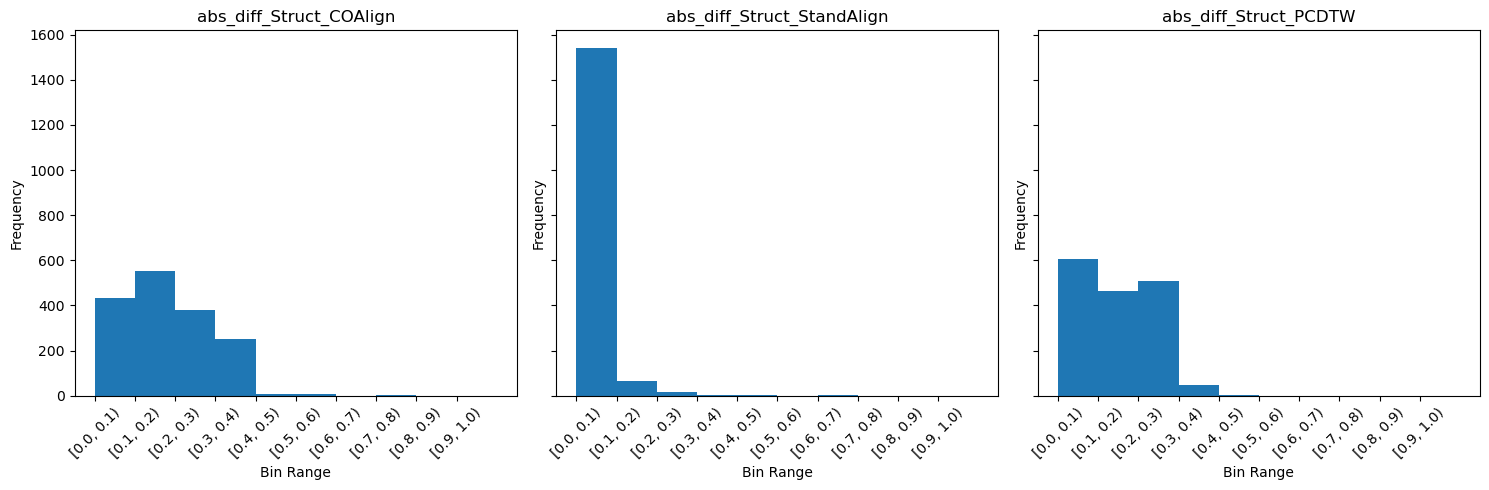

0.6550990903517481


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define bin edges from 0 to 1 with 0.05 width
bin_edges = np.arange(0, 1.05, 0.1)  # 1.05 to include 1

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
axes = axes.flatten()

# List of columns to bin and plot
columns = ["abs_diff_Struct_COAlign", "abs_diff_Struct_StandAlign", "abs_diff_Struct_PCDTW"]

for idx, col in enumerate(columns):
    # Bin the data
    binned_data = pd.cut(sorted_df[col], bins=bin_edges, include_lowest=True, right=False)
    
    # Count frequencies in each bin
    bin_counts = binned_data.value_counts().sort_index()
    
    # Plot histogram
    axes[idx].bar(bin_counts.index.astype(str), bin_counts.values, width=1, align='edge')
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Bin Range')
    axes[idx].set_ylabel('Frequency')
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

# Calculate the 99th percentile for abs_diff_Struct_StandAlign
threshold = np.percentile(sorted_df['abs_diff_Struct_StandAlign'], 99.99)
print(threshold)

In [20]:

df.to_pickle("C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/CYP51 Followup Comparisons/1630_5NNStructure_to_Align.pkl")

In [6]:
#This is used to make sure each tree and fasta file have the exact same list of names.

structure_tree_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Trees/FT_of_1630_Reviewed_UniProt_CYPP450s.nwk"
pcdtw_tree_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Trees/MWHPPCDTW_of_1630_Reviewed_UniProt_CYPP450s.nwk"
sequence_align_tree_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Trees/ClustalO_of_1630_Reviewed_UniProt_CYPP450s.nwk"
fasta_file="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/DataSets/1630 CYPP450s on both AlphaFold and Uniprot(Reviewed) Seq_Struct_Analysis/Sequences/CYP450AFSeqs1630.fasta"

from Bio import Phylo, SeqIO
from collections import defaultdict

def extract_leaf_names(newick_file):
    tree = Phylo.read(newick_file, "newick")
    return set(clade.name for clade in tree.get_terminals() if clade.name)

def extract_fasta_headers(fasta_file):
    return set(record.id for record in SeqIO.parse(fasta_file, "fasta"))

# Input files
tree_files = [structure_tree_file, pcdtw_tree_file, sequence_align_tree_file]
fasta_file = fasta_file
all_sources = tree_files + [fasta_file]

# Extract sets
tree_sets = [extract_leaf_names(f) for f in tree_files]
fasta_set = extract_fasta_headers(fasta_file)

all_sets = tree_sets + [fasta_set]

# Build presence map
name_sources = defaultdict(list)
for name_set, source in zip(all_sets, all_sources):
    for name in name_set:
        name_sources[name].append(source)

# Separate names
common_names = sorted([name for name, sources in name_sources.items() if len(sources) == 4])
non_common_names = sorted([name for name, sources in name_sources.items() if len(sources) < 4])

# # Output results
# print(f"Common names in all 4 files ({len(common_names)}):")
# print(common_names)

print(f"\nNames not shared by all files ({len(non_common_names)}):")
for name in non_common_names:
    print(f"{name}: found in {name_sources[name]}")
    




Names not shared by all files (0):


In [23]:
import pickle
filename2="C:/Users/jamie/OneDrive/Documents/Biology Projects/CYP450 Manuscript for GBE/CYP51 Followup Comparisons/1630_TreeDistanceMatrices.pkl"
# Save the dictionary to a pickle file
with open(filename2, "wb") as f:
    pickle.dump(matrices, f)

with open(filename2, "rb") as f:
    loaded_matrices = pickle.load(f)

print(loaded_matrices)

{'Structure': array([[0.        , 0.75511728, 0.75854865, ..., 0.89153849, 0.8961822 ,
        0.8961822 ],
       [0.75511728, 0.        , 0.22474914, ..., 0.88309537, 0.88773909,
        0.88773909],
       [0.75854865, 0.22474914, 0.        , ..., 0.88652674, 0.89117045,
        0.89117045],
       ...,
       [0.89153849, 0.88309537, 0.88652674, ..., 0.        , 0.20128162,
        0.20128162],
       [0.8961822 , 0.88773909, 0.89117045, ..., 0.20128162, 0.        ,
        0.09525562],
       [0.8961822 , 0.88773909, 0.89117045, ..., 0.20128162, 0.09525562,
        0.        ]]), 'PCDTW': array([[0.        , 0.37254356, 0.37254356, ..., 0.45716411, 0.42197475,
        0.42197475],
       [0.37254356, 0.        , 0.24012864, ..., 0.45716411, 0.42197475,
        0.42197475],
       [0.37254356, 0.24012864, 0.        , ..., 0.45716411, 0.42197475,
        0.42197475],
       ...,
       [0.45716411, 0.45716411, 0.45716411, ..., 0.        , 0.45715451,
        0.45715451],
       [0.4

In [24]:
def compute_matrix_correlations(matrix_dict):
    import numpy as np
    import pandas as pd
    from scipy.stats import pearsonr
    from itertools import combinations

    def get_flattened_upper(matrix):
        if isinstance(matrix, pd.DataFrame):
            matrix = matrix.values
        return matrix[np.triu_indices_from(matrix, k=1)]

    results = []
    keys = list(matrix_dict.keys())

    for key1, key2 in combinations(keys, 2):
        v1 = get_flattened_upper(matrix_dict[key1])
        v2 = get_flattened_upper(matrix_dict[key2])
        r, p = pearsonr(v1, v2)
        results.append({
            "Matrix 1": key1,
            "Matrix 2": key2,
            "Pearson r": r,
            "p-value": p
        })

    return pd.DataFrame(results)

correlation_df = compute_matrix_correlations(loaded_matrices)


print(correlation_df)

    Matrix 1    Matrix 2  Pearson r  p-value
0  Structure       PCDTW   0.298682      0.0
1  Structure     COAlign   0.576916      0.0
2  Structure  StandAlign   0.779453      0.0
3      PCDTW     COAlign   0.283434      0.0
4      PCDTW  StandAlign   0.536194      0.0
5    COAlign  StandAlign   0.524798      0.0


In [28]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from itertools import combinations

def compute_matrix_correlations(matrix_dict):
    def get_flattened_upper(matrix):
        if isinstance(matrix, pd.DataFrame):
            matrix = matrix.values
        if not np.all(np.isfinite(matrix)):
            raise ValueError("Matrix contains non-finite values (NaN or Inf)")
        return matrix[np.triu_indices_from(matrix, k=1)]

    results = []
    keys = list(matrix_dict.keys())

    for key1, key2 in combinations(keys, 2):
        v1 = get_flattened_upper(matrix_dict[key1])
        v2 = get_flattened_upper(matrix_dict[key2])
        
        # Check for valid input lengths
        if len(v1) != len(v2) or len(v1) < 2:
            raise ValueError(f"Invalid input length for matrices {key1} and {key2}: {len(v1)}")
        
        # Compute Pearson correlation and p-value
        r, p = pearsonr(v1, v2)
        
        # Warn if p-value is extremely small
        if p < 1e-16:
            print(f"Warning: Very small p-value ({p:.6e}) for {key1} vs {key2}. Sample size: {len(v1)}")
        
        results.append({
            "Matrix 1": key1,
            "Matrix 2": key2,
            "Pearson r": r,
            "p-value": p,
            "Sample Size": len(v1)
        })

    df = pd.DataFrame(results)
    # Format p-value in scientific notation with 6 significant figures
    df['p-value'] = df['p-value'].apply(lambda x: f"{x:.6e}")
    return df

# Verify input matrices before processing
for key, matrix in loaded_matrices.items():
    if not isinstance(matrix, (np.ndarray, pd.DataFrame)):
        raise TypeError(f"Matrix {key} is not a numpy array or pandas DataFrame")
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError(f"Matrix {key} is not square")

correlation_df = compute_matrix_correlations(loaded_matrices)
print(correlation_df)

    Matrix 1    Matrix 2  Pearson r       p-value  Sample Size
0  Structure       PCDTW   0.298682  0.000000e+00      1327635
1  Structure     COAlign   0.576916  0.000000e+00      1327635
2  Structure  StandAlign   0.779453  0.000000e+00      1327635
3      PCDTW     COAlign   0.283434  0.000000e+00      1327635
4      PCDTW  StandAlign   0.536194  0.000000e+00      1327635
5    COAlign  StandAlign   0.524798  0.000000e+00      1327635
